## リアルタイム Parabolic SAR (rtpsar) 検証用

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

### 必要なライブラリをまとめてインポート

In [2]:
import datetime
import re

from matplotlib import (
    dates as mdates,
    font_manager as fm,
    pyplot as plt,
    ticker as ticker,
)
import numpy as np
import pandas as pd

from funcs.plots import getMajorXTicks
from funcs.preprocs_no_qt import get_date_formatted
from tech.rtpsar import RealTimePSAR

### 過去ログ (Tick) の読み込み

In [3]:
code = '7011'
#code = '7203'
#code = '8306'
dateStr = '20250424'

In [5]:
dateFmt = get_date_formatted(dateStr)
tick_excel = '../excel/trader_%s.xlsm' % dateStr
sheet = 'tick_%s' % code
df = pd.read_excel(tick_excel, sheet_name=sheet)

# Tick データを Matplotlib で扱いやすいように整形
list_datetime = [pd.to_datetime('%s %s'% (dateStr, t)) for t in df['Time']]
df.index = list_datetime
df = pd.DataFrame(df['Price'])
df

,Price
2025-04-24 09:00:00,2671.5
2025-04-24 09:00:01,2675.0
2025-04-24 09:00:03,2678.0
2025-04-24 09:00:05,2679.0
2025-04-24 09:00:07,2670.0
...,...
2025-04-24 15:24:53,2693.0
2025-04-24 15:24:56,2692.5
2025-04-24 15:24:57,2692.0
2025-04-24 15:24:59,2692.0


### RealTimePSAR インスタンス

In [6]:
af_init=0.0000
af_step=0.0001
af_max=0.001
q = 50
psar = RealTimePSAR(af_init, af_step, af_max, q)

for r in range(len(df)):
    t = df.index[r]
    price = df.loc[t, 'Price']
    psar.add(t, price)

df_psar = psar.getPSAR()
df_psar

,Price,TREND,EP,AF,PSAR,Baseline,Losscut,TrendN,EPupd
Datetime,,,,,,,,,
2025-04-24 09:00:00,2671.5,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2025-04-24 09:00:01,2675.0,1.0,2675.0,0.0000,2675.000000,2675.0,NaN,1.0,0.0
2025-04-24 09:00:03,2678.0,1.0,2678.0,0.0001,2675.000300,2675.0,NaN,2.0,1.0
2025-04-24 09:00:05,2679.0,1.0,2679.0,0.0002,2675.001100,2675.0,NaN,3.0,2.0
2025-04-24 09:00:07,2670.0,-1.0,2670.0,0.0000,2679.000000,2670.0,2679.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2025-04-24 15:24:53,2693.0,-1.0,2691.0,0.0004,2701.443963,2693.5,2694.116438,681.0,4.0
2025-04-24 15:24:56,2692.5,-1.0,2691.0,0.0004,2701.439785,2693.5,2694.115595,682.0,4.0
2025-04-24 15:24:57,2692.0,-1.0,2691.0,0.0004,2701.435609,2693.5,2694.114754,683.0,4.0


### チャート

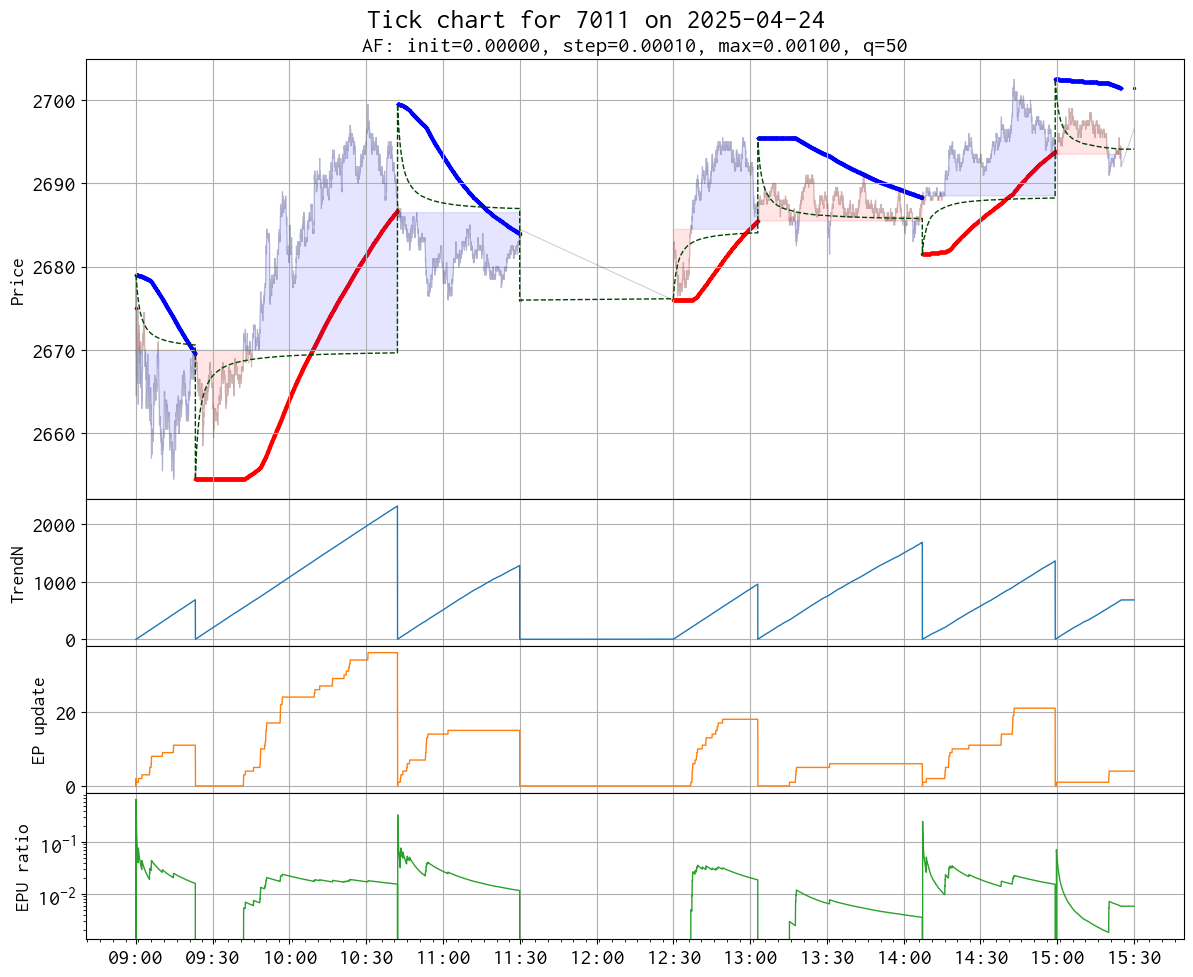

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

ax = dict()
n = 4

if n > 1:
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(
        n, 1,
        wspace=0.0, hspace=0.0,
        height_ratios=[3 if i == 0 else 1 for i in range(n)]
    )
    for i, axis in enumerate(gs.subplots(sharex='col')):
        ax[i] = axis
        ax[i].grid()
else:
    fig, ax[0] = plt.subplots(figsize=(12, 6))
    ax[0].grid()

# Tick
ax[0].plot(df_psar['Price'], linewidth=0.75, color='black', alpha=0.2)

# PSAR bear - Downward trend
df_bear = df_psar[df_psar['TREND'] < 0]
ax[0].scatter(x=df_bear.index, y=df_bear['PSAR'], color='blue', s=2)

# PSAR bull - Upward trend
df_bull = df_psar[df_psar['TREND'] > 0]
ax[0].scatter(x=df_bull.index, y=df_bull['PSAR'], color='red', s=2)

# Price vs. Baseline
color_gain = '#00f'
color_loss = '#f00'
alpha = 0.1
df_psar_bear = df_psar[df_psar['TREND'] < 0]
x = df_psar_bear.index
y1 = df_psar_bear['Price']
y2 = df_psar_bear['Baseline']
ax[0].fill_between(x, y1, y2, where=(y1 < y2), color=color_gain, alpha=alpha)
ax[0].fill_between(x, y1, y2, where=(y1 > y2), color=color_loss, alpha=alpha)

df_psar_bull = df_psar[df_psar['TREND'] > 0]
x = df_psar_bull.index
y1 = df_psar_bull['Price']
y2 = df_psar_bull['Baseline']
ax[0].fill_between(x, y1, y2, where=(y1 > y2), color=color_gain, alpha=alpha)
ax[0].fill_between(x, y1, y2, where=(y1 < y2), color=color_loss, alpha=alpha)

# ロスカット用補助線
if 'Losscut' in df_psar.columns:
    ax[0].plot(df_psar['Losscut'], linewidth=1, linestyle='dashed', color='#040', label='Losscut')

tick_position, tick_labels = getMajorXTicks(df)
ax[0].set_xticks(ticks=tick_position, labels=tick_labels,)
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].set_ylabel('Price', fontsize=14)

ax[0].set_title('AF: init=%.5f, step=%.5f, max=%.5f, q=%d' % (af_init, af_step, af_max, q), fontsize=16)

ax[1].plot(df_psar['TrendN'], linewidth=1, color='C0')
ax[1].set_ylabel('TrendN', fontsize=14)

ax[2].plot(df_psar['EPupd'], linewidth=1, color='C1')
ax[2].set_ylabel('EP update', fontsize=14)

ax[3].semilogy(df_psar['EPupd'] / df_psar['TrendN'], linewidth=1, color='C2')
ax[3].set_ylabel('EPU ratio', fontsize=14)

suptitle = 'Tick chart for %s on %s' % (code, dateFmt)
plt.suptitle(suptitle, fontsize=20)

#plt.tight_layout()
plt.subplots_adjust(left=0.075, right=0.99, bottom=0.05, top=0.93)
plt.savefig('screenshots/tick_chart_%s_%s.png' % (code, dateFmt))
plt.show()